In [1]:
import logging 

logging.basicConfig(
  format = '%(asctime)s %(message)s',
  level=logging.INFO,
  datefmt='%Y-%m-%d %H:%M:%S'
)

In [2]:
import pyranges as pr

CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'
cpg_islands_path = f'{CONSTRAINT_TOOLS_DATA}/cpg-islands/grch38/cpg-islands.sorted.bed.gz'

# https://biocore-ntnu.github.io/pyranges/loadingcreating-pyranges.html
cpg_islands = pr.read_bed(cpg_islands_path)

cpg_islands.columns = ['Chromosome', 'Start', 'End', 'Name', 'Length', 'cpgNum', 'gcNum', 'perCpg', 'perGc', 'obsExp']
cpg_islands

,Chromosome,Start,End,Name,Length,cpgNum,gcNum,perCpg,perGc,obsExp
0,chr1,28735,29737,CpG: 111,1002,111,731,22.2,73.0,0.85
1,chr1,135124,135563,CpG: 30,439,30,295,13.7,67.2,0.64
2,chr1,199251,200121,CpG: 104,870,104,643,23.9,73.9,0.89
3,chr1,368792,370063,CpG: 99,1271,99,777,15.6,61.1,0.84
4,chr1,381172,382185,CpG: 84,1013,84,734,16.6,72.5,0.64
...,...,...,...,...,...,...,...,...,...,...
27944,chrY,25464370,25464941,CpG: 51,571,51,403,17.9,70.6,0.72
27945,chrY,26409388,26409785,CpG: 32,397,32,252,16.1,63.5,0.82
27946,chrY,26627168,26627397,CpG: 25,229,25,172,21.8,75.1,0.78
27947,chrY,57067645,57068034,CpG: 36,389,36,257,18.5,66.1,0.85


In [3]:
import sys
sys.path.append('/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/utilities')

from read_model import read_model 

model = read_model('/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/dist/model-germline-grch38.json')

# https://biocore-ntnu.github.io/pyranges/loadingcreating-pyranges.html
neutral_regions = pr.read_bed(model['neutralRegions'])

neutral_regions

,Chromosome,Start,End
0,chr1,14653,14905
1,chr1,15354,15772
2,chr1,16125,16607
3,chr1,17055,17171
4,chr1,17436,17606
...,...,...,...
1649454,chr22,50794754,50796286
1649455,chr22,50796386,50796692
1649456,chr22,50796780,50796942
1649457,chr22,50797586,50797812


In [4]:
cpg_islands.cpg_island_id = cpg_islands.df.index.values
cpg_islands

,Chromosome,Start,End,Name,Length,cpgNum,gcNum,perCpg,perGc,obsExp,cpg_island_id
0,chr1,28735,29737,CpG: 111,1002,111,731,22.2,73.0,0.85,0
1,chr1,135124,135563,CpG: 30,439,30,295,13.7,67.2,0.64,1
2,chr1,199251,200121,CpG: 104,870,104,643,23.9,73.9,0.89,2
3,chr1,368792,370063,CpG: 99,1271,99,777,15.6,61.1,0.84,3
4,chr1,381172,382185,CpG: 84,1013,84,734,16.6,72.5,0.64,4
...,...,...,...,...,...,...,...,...,...,...,...
27944,chrY,25464370,25464941,CpG: 51,571,51,403,17.9,70.6,0.72,27944
27945,chrY,26409388,26409785,CpG: 32,397,32,252,16.1,63.5,0.82,27945
27946,chrY,26627168,26627397,CpG: 25,229,25,172,21.8,75.1,0.78,27946
27947,chrY,57067645,57068034,CpG: 36,389,36,257,18.5,66.1,0.85,27947


In [5]:
# https://pyranges.readthedocs.io/en/latest/autoapi/pyranges/pyranges/index.html?highlight=intersect#pyranges.pyranges.PyRanges.overlap

cpg_islands_that_overlap_neutral_regions = cpg_islands.overlap(neutral_regions).df
cpg_islands_that_overlap_neutral_regions

,Chromosome,Start,End,Name,Length,cpgNum,gcNum,perCpg,perGc,obsExp,cpg_island_id
0,chr1,135124,135563,CpG: 30,439,30,295,13.7,67.2,0.64,1
1,chr1,778604,779167,CpG: 60,563,60,385,21.3,68.4,0.92,8
2,chr1,869818,870248,CpG: 50,430,50,316,23.3,73.5,0.87,12
3,chr1,904314,905239,CpG: 119,925,119,693,25.7,74.9,0.92,13
4,chr1,908919,910503,CpG: 154,1584,154,1106,19.4,69.8,0.82,14
...,...,...,...,...,...,...,...,...,...,...,...
21422,chr22,50697242,50697698,CpG: 56,456,56,327,24.6,71.7,0.96,26860
21423,chr22,50704374,50704880,CpG: 38,506,38,328,15.0,64.8,0.72,26861
21424,chr22,50710877,50711294,CpG: 41,417,41,267,19.7,64.0,1.01,26862
21425,chr22,50719958,50721632,CpG: 180,1674,180,1209,21.5,72.2,0.84,26863


In [6]:
# https://pyranges.readthedocs.io/en/latest/autoapi/pyranges/pyranges/index.html?highlight=intersect#pyranges.pyranges.PyRanges.intersect

neutral_regions_within_cpg_islands = cpg_islands.intersect(neutral_regions).df[['Start', 'End', 'cpg_island_id']]
neutral_regions_within_cpg_islands


,Start,End,cpg_island_id
0,135124,135141,1
1,779092,779167,8
2,869818,870086,12
3,870201,870248,12
4,904314,904478,13
...,...,...,...
35769,50710983,50711117,26862
35770,50711118,50711224,26862
35771,50711225,50711294,26862
35772,50719958,50720184,26863


In [7]:
import pandas as pd

cpg_islands_with_neutral_regions = pd.merge(
  cpg_islands_that_overlap_neutral_regions, 
  neutral_regions_within_cpg_islands, 
  on='cpg_island_id', 
  how='inner'
)
cpg_islands_with_neutral_regions = cpg_islands_with_neutral_regions.rename(columns={
  "Start_x": "Start_cpg_island", 
  "End_x": "End_cpg_island",
  "Start_y": "Start_neutral_part", 
  "End_y": "End_neutral_part",
})
cpg_islands_with_neutral_regions


,Chromosome,Start_cpg_island,End_cpg_island,Name,Length,cpgNum,gcNum,perCpg,perGc,obsExp,cpg_island_id,Start_neutral_part,End_neutral_part
0,chr1,135124,135563,CpG: 30,439,30,295,13.7,67.2,0.64,1,135124,135141
1,chr1,778604,779167,CpG: 60,563,60,385,21.3,68.4,0.92,8,779092,779167
2,chr1,869818,870248,CpG: 50,430,50,316,23.3,73.5,0.87,12,869818,870086
3,chr1,869818,870248,CpG: 50,430,50,316,23.3,73.5,0.87,12,870201,870248
4,chr1,904314,905239,CpG: 119,925,119,693,25.7,74.9,0.92,13,904314,904478
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35769,chr22,50710877,50711294,CpG: 41,417,41,267,19.7,64.0,1.01,26862,50710983,50711117
35770,chr22,50710877,50711294,CpG: 41,417,41,267,19.7,64.0,1.01,26862,50711118,50711224
35771,chr22,50710877,50711294,CpG: 41,417,41,267,19.7,64.0,1.01,26862,50711225,50711294
35772,chr22,50719958,50721632,CpG: 180,1674,180,1209,21.5,72.2,0.84,26863,50719958,50720184


In [8]:
def compute_neutral_part_length(row):
  return row['End_neutral_part'] - row['Start_neutral_part']

cpg_islands_with_neutral_regions['neutral_part_length'] = cpg_islands_with_neutral_regions.apply(compute_neutral_part_length, axis=1)
cpg_islands_with_neutral_regions

,Chromosome,Start_cpg_island,End_cpg_island,Name,Length,cpgNum,gcNum,perCpg,perGc,obsExp,cpg_island_id,Start_neutral_part,End_neutral_part,neutral_part_length
0,chr1,135124,135563,CpG: 30,439,30,295,13.7,67.2,0.64,1,135124,135141,17
1,chr1,778604,779167,CpG: 60,563,60,385,21.3,68.4,0.92,8,779092,779167,75
2,chr1,869818,870248,CpG: 50,430,50,316,23.3,73.5,0.87,12,869818,870086,268
3,chr1,869818,870248,CpG: 50,430,50,316,23.3,73.5,0.87,12,870201,870248,47
4,chr1,904314,905239,CpG: 119,925,119,693,25.7,74.9,0.92,13,904314,904478,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35769,chr22,50710877,50711294,CpG: 41,417,41,267,19.7,64.0,1.01,26862,50710983,50711117,134
35770,chr22,50710877,50711294,CpG: 41,417,41,267,19.7,64.0,1.01,26862,50711118,50711224,106
35771,chr22,50710877,50711294,CpG: 41,417,41,267,19.7,64.0,1.01,26862,50711225,50711294,69
35772,chr22,50719958,50721632,CpG: 180,1674,180,1209,21.5,72.2,0.84,26863,50719958,50720184,226


In [9]:
cpg_islands_with_neutral_regions = cpg_islands_with_neutral_regions[['cpg_island_id', 'neutral_part_length']]
cpg_islands_with_neutral_regions 


,cpg_island_id,neutral_part_length
0,1,17
1,8,75
2,12,268
3,12,47
4,13,164
...,...,...
35769,26862,134
35770,26862,106
35771,26862,69
35772,26863,226


In [10]:
grouped_neutral_regions = cpg_islands_with_neutral_regions.groupby('cpg_island_id')

number_neutral_bases = grouped_neutral_regions['neutral_part_length'].sum().rename("number_neutral_bases")
number_neutral_bases

cpg_island_id
1         17
8         75
12       315
13       422
14       547
        ... 
26860    204
26861    382
26862    414
26863    226
26864    122
Name: number_neutral_bases, Length: 21427, dtype: int64

In [11]:
number_neutral_parts = grouped_neutral_regions['neutral_part_length'].count().rename('number_neutral_parts')
number_neutral_parts

cpg_island_id
1        1
8        1
12       2
13       3
14       2
        ..
26860    1
26861    2
26862    4
26863    1
26864    1
Name: number_neutral_parts, Length: 21427, dtype: int64

In [12]:
cpg_islands = ( 
  cpg_islands.df
  .merge(number_neutral_bases, on='cpg_island_id', how='inner')
  .merge(number_neutral_parts, on='cpg_island_id', how='inner')
)

cpg_islands

,Chromosome,Start,End,Name,Length,cpgNum,gcNum,perCpg,perGc,obsExp,cpg_island_id,number_neutral_bases,number_neutral_parts
0,chr1,135124,135563,CpG: 30,439,30,295,13.7,67.2,0.64,1,17,1
1,chr1,778604,779167,CpG: 60,563,60,385,21.3,68.4,0.92,8,75,1
2,chr1,869818,870248,CpG: 50,430,50,316,23.3,73.5,0.87,12,315,2
3,chr1,904314,905239,CpG: 119,925,119,693,25.7,74.9,0.92,13,422,3
4,chr1,908919,910503,CpG: 154,1584,154,1106,19.4,69.8,0.82,14,547,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21422,chr22,50697242,50697698,CpG: 56,456,56,327,24.6,71.7,0.96,26860,204,1
21423,chr22,50704374,50704880,CpG: 38,506,38,328,15.0,64.8,0.72,26861,382,2
21424,chr22,50710877,50711294,CpG: 41,417,41,267,19.7,64.0,1.01,26862,414,4
21425,chr22,50719958,50721632,CpG: 180,1674,180,1209,21.5,72.2,0.84,26863,226,1


In [13]:
# https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/03_subset_data.html#how-do-i-filter-specific-rows-from-a-dataframe
cpg_islands = cpg_islands[(cpg_islands.number_neutral_bases > 1000) & (cpg_islands.number_neutral_parts < 5)]
cpg_islands

,Chromosome,Start,End,Name,Length,cpgNum,gcNum,perCpg,perGc,obsExp,cpg_island_id,number_neutral_bases,number_neutral_parts
9,chr1,940225,942983,CpG: 254,2758,254,1906,18.4,69.1,0.77,20,1474,3
14,chr1,998007,1002030,CpG: 410,4023,410,2687,20.4,66.8,0.91,26,2176,3
19,chr1,1032586,1034858,CpG: 183,2272,183,1379,16.1,60.7,0.87,31,1391,3
20,chr1,1040116,1044925,CpG: 347,4809,347,3111,14.4,64.7,0.69,32,2218,4
33,chr1,1115135,1117065,CpG: 186,1930,186,1276,19.3,66.1,0.91,53,1214,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21364,chr22,49826470,49828021,CpG: 215,1551,215,1121,27.7,72.3,1.06,26782,1038,2
21371,chr22,49959948,49963567,CpG: 398,3619,398,2519,22.0,69.6,0.91,26790,1600,3
21383,chr22,50184735,50186797,CpG: 170,2062,170,1204,16.5,58.4,0.98,26807,1426,4
21392,chr22,50269761,50272004,CpG: 175,2243,175,1346,15.6,60.0,0.87,26821,1837,4


In [14]:
sys.path.append('/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/predict-constraint/germline-model')

import numpy as np 

from expected_observed_counts import compute_expected_observed_counts
from pack_unpack import pack

window_stride = 10 

def filter_and_average(xs): 
  xs_filtered = [x for x in xs if x]
  return np.mean(xs_filtered) 

def compute_neutral_zscores(row): 
  region = pack(row.Chromosome, row.Start, row.End)  
  expected_observed_counts = compute_expected_observed_counts(region, model, window_stride, log=False) 
  # https://www.dataquest.io/blog/settingwithcopywarning/
  with pd.option_context('mode.chained_assignment', None):
    row['N_bar_mean_neutral'] = filter_and_average(expected_observed_counts['NBarsNeutralRegions'])
    row['K_bar_mean_neutral'] = filter_and_average(expected_observed_counts['KBarsNeutralRegions'])
  return row 

# https://stackoverflow.com/a/34365537/6674256
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()
logging.info('Computing z-scores for cpg islands...')
cpg_islands_with_zscores = cpg_islands.progress_apply(compute_neutral_zscores, axis=1)
logging.info('...finished computing z-scores for cpg islands...')

cpg_islands_with_zscores.head()

/uufs/chpc.utah.edu/common/HIPAA/u6018199/.conda/envs/constraint-tools/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-05-26 16:40:37 Computing z-scores for cpg islands...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1435/1435 [2:05:05<00:00,  5.23s/it]
2022-05-26 18:45:42 ...finished computing z-scores for cpg islands...


,Chromosome,Start,End,Name,Length,cpgNum,gcNum,perCpg,perGc,obsExp,cpg_island_id,number_neutral_bases,number_neutral_parts,N_bar_mean_neutral,K_bar_mean_neutral
9,chr1,940225,942983,CpG: 254,2758,254,1906,18.4,69.1,0.77,20,1474,3,1.371440,0.251313
14,chr1,998007,1002030,CpG: 410,4023,410,2687,20.4,66.8,0.91,26,2176,3,-0.636782,0.755663
19,chr1,1032586,1034858,CpG: 183,2272,183,1379,16.1,60.7,0.87,31,1391,3,-1.143479,0.462467
20,chr1,1040116,1044925,CpG: 347,4809,347,3111,14.4,64.7,0.69,32,2218,4,0.108947,-0.320407
33,chr1,1115135,1117065,CpG: 186,1930,186,1276,19.3,66.1,0.91,53,1214,4,-2.260381,0.225095


In [15]:
cpg_islands_with_zscores_path = f'{CONSTRAINT_TOOLS_DATA}/cpg-islands/grch38/cpg-islands-with-zscores.bed'

cpg_islands_with_zscores.to_csv(cpg_islands_with_zscores_path, index=False, sep='\t')

<AxesSubplot:xlabel='perCpg', ylabel='K_bar_mean_neutral'>

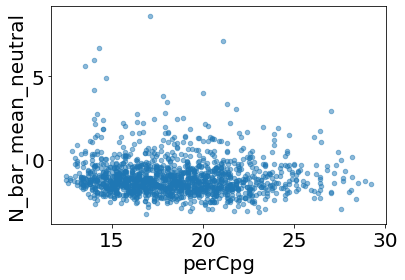

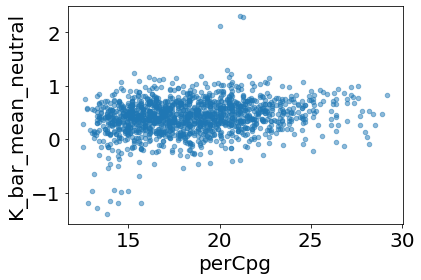

In [16]:
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 20})

cpg_islands_with_zscores.plot.scatter(x="perCpg", y="N_bar_mean_neutral", alpha=0.5)
cpg_islands_with_zscores.plot.scatter(x="perCpg", y="K_bar_mean_neutral", alpha=0.5)